# 3- Check if any other rescaling of data or initialization of weights may improve the accuracy of the DNN.

In [1]:
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

from sklearn.model_selection     import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics             import confusion_matrix


%load_ext autoreload
%autoreload 1
%aimport nn_model
%aimport create_data
%aimport preprocess
%aimport plot_utils

## Generate data

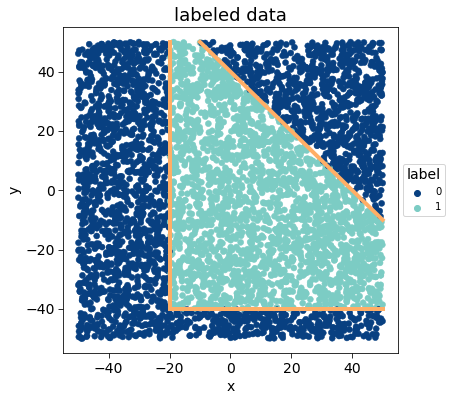

In [2]:
# number of data
N = 5000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x, y_true = create_data.create_data(N, B, c="triang")

fig = plt.figure(figsize=(6,6))
ax  = plot_utils.plot_labeled_data(
    x               = x, 
    labels          = y_true, 
    fig             = fig, 
    title           = "labeled data", 
    palette         = "GnBu_r",
    hue_norm        = (0, 2),
    fontsize        = 14, 
    show_boundaries = True
)

plt.show()

## Data rescalings

Rescaling functions can be found in ```preprocess.py```

1) No rescaling
2) Standardization
3) Normalization

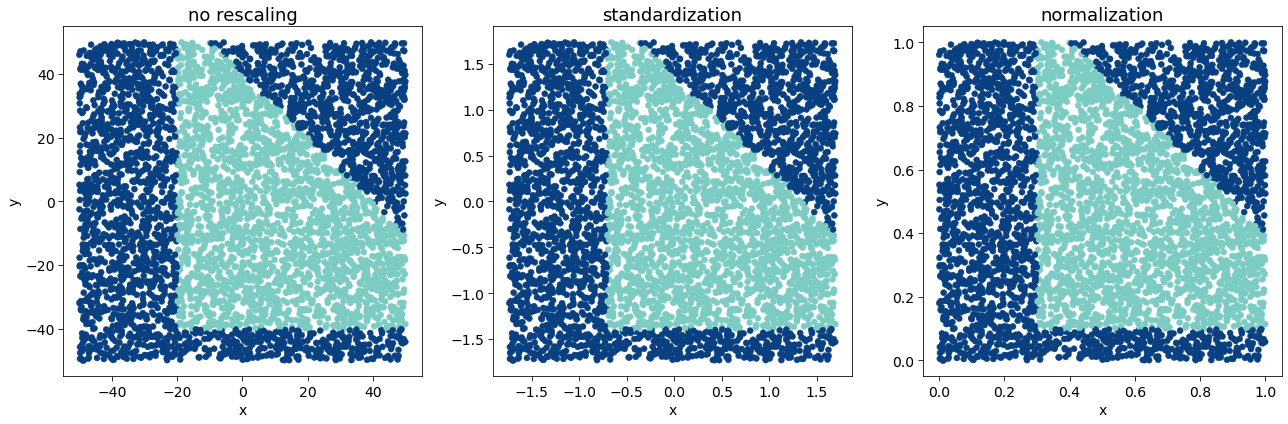

In [3]:
mean = np.mean(x, axis=0) 
std  = np.std(x, axis=0)

# no rescaling
x_nr   = np.copy(x)
# standardization
x_std  = preprocess.standardize(x, mean, std)
# normalization
x_norm = preprocess.normalize(x)

dataset = np.array([x_nr, x_std, x_norm])
titles  = ["no rescaling", "standardization", "normalization"]

fig = plt.figure(figsize=(18,6), constrained_layout=True)

for i, data in enumerate(dataset):
    ax  = plot_utils.plot_labeled_data(
        x               = data, 
        labels          = y_true, 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
plt.show()

### Training, test, validation

In [4]:
train_test_frac  = 0.7
valid_train_frac = 0.2 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

data_split = {
    "training_set"   : N_train,
    "test_set"       : N_test,
    "validation_set" : N_valid
}

for key, val in data_split.items():
    print(f"{key} \t N = {val}")

training_set      = []
training_labels   = []
test_set          = []
test_labels       = []
validation_set    = []
validation_labels = []

for data in dataset:

    training_set.append(data[0:train_idx])
    training_labels.append(y_true[0:train_idx])

    validation_set.append(data[train_idx:valid_idx])
    validation_labels.append(y_true[train_idx:valid_idx])

    test_set.append(data[valid_idx:test_idx])
    test_labels.append(y_true[valid_idx:test_idx])

training_set 	 N = 2800
test_set 	 N = 1500
validation_set 	 N = 700


### Neural network hyper-parameters

In [5]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [2] # [1]
dropout_rates     = [0.2] # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "RMSprop"
metrics   = ["accuracy"]

### Training

In [6]:
# training parameters
minibatch = 64
N_epochs  = 200

networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)


no rescaling training : 41.99 seconds

training loss     : 0.04762
training accuracy : 0.98107

valid loss        : 0.03815
valid accuracy    : 0.98143


no rescaling testing

test loss         : 0.05236
test accuracy     : 0.97800


standardization training : 41.72 seconds

training loss     : 0.01528
training accuracy : 0.99536

valid loss        : 0.01133
valid accuracy    : 0.99571


standardization testing

test loss         : 0.01338
test accuracy     : 0.99600


normalization training : 22.39 seconds

training loss     : 0.03044
training accuracy : 0.98893

valid loss        : 0.01788
valid accuracy    : 0.99857


normalization testing

test loss         : 0.02322
test accuracy     : 0.99667



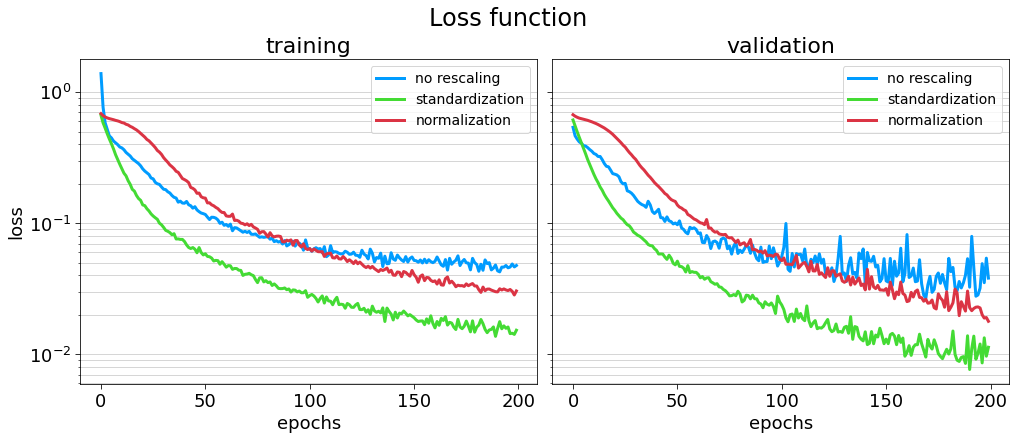

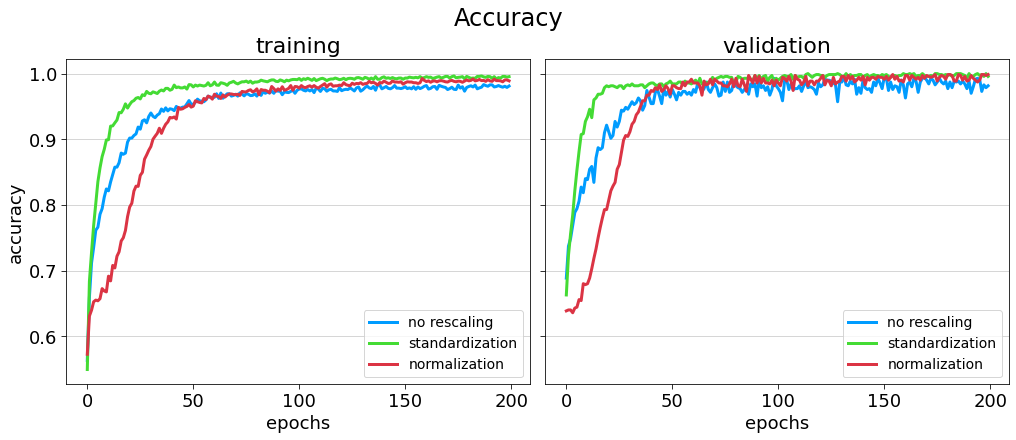

In [7]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

### Weights and biases

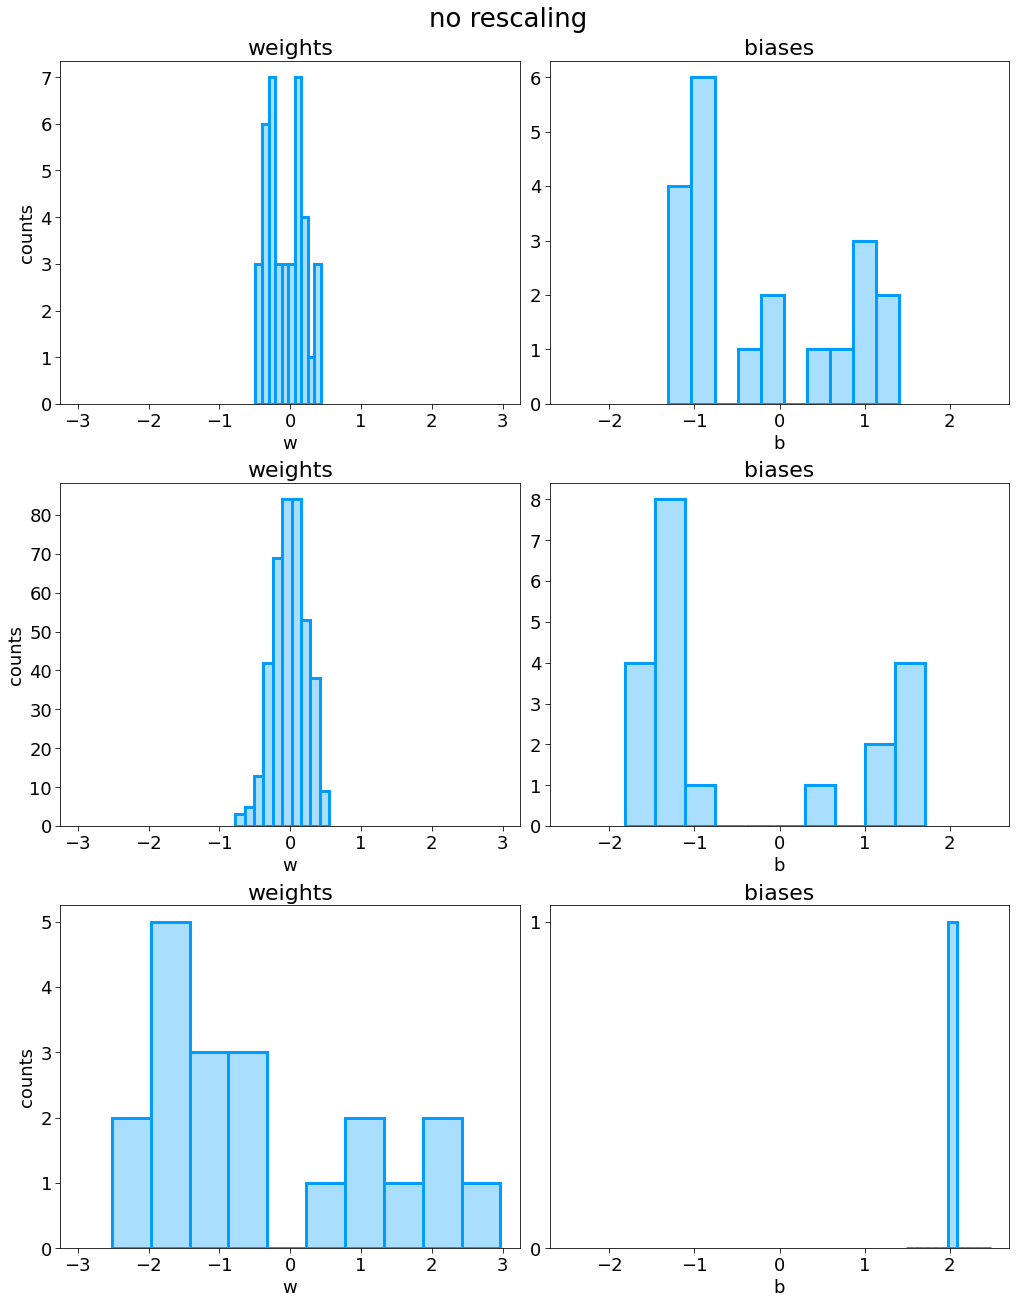

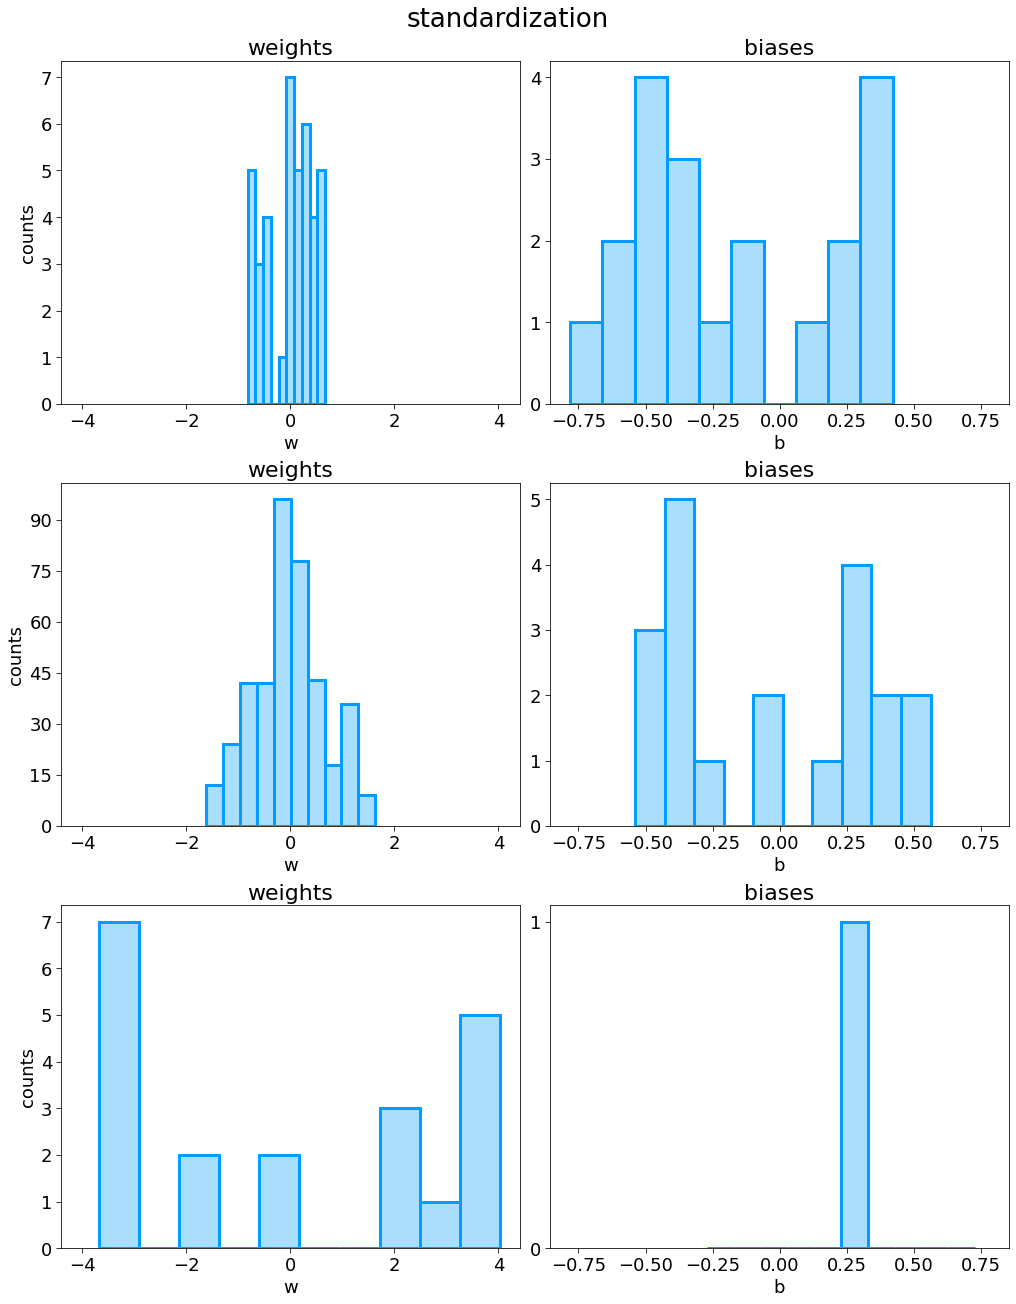

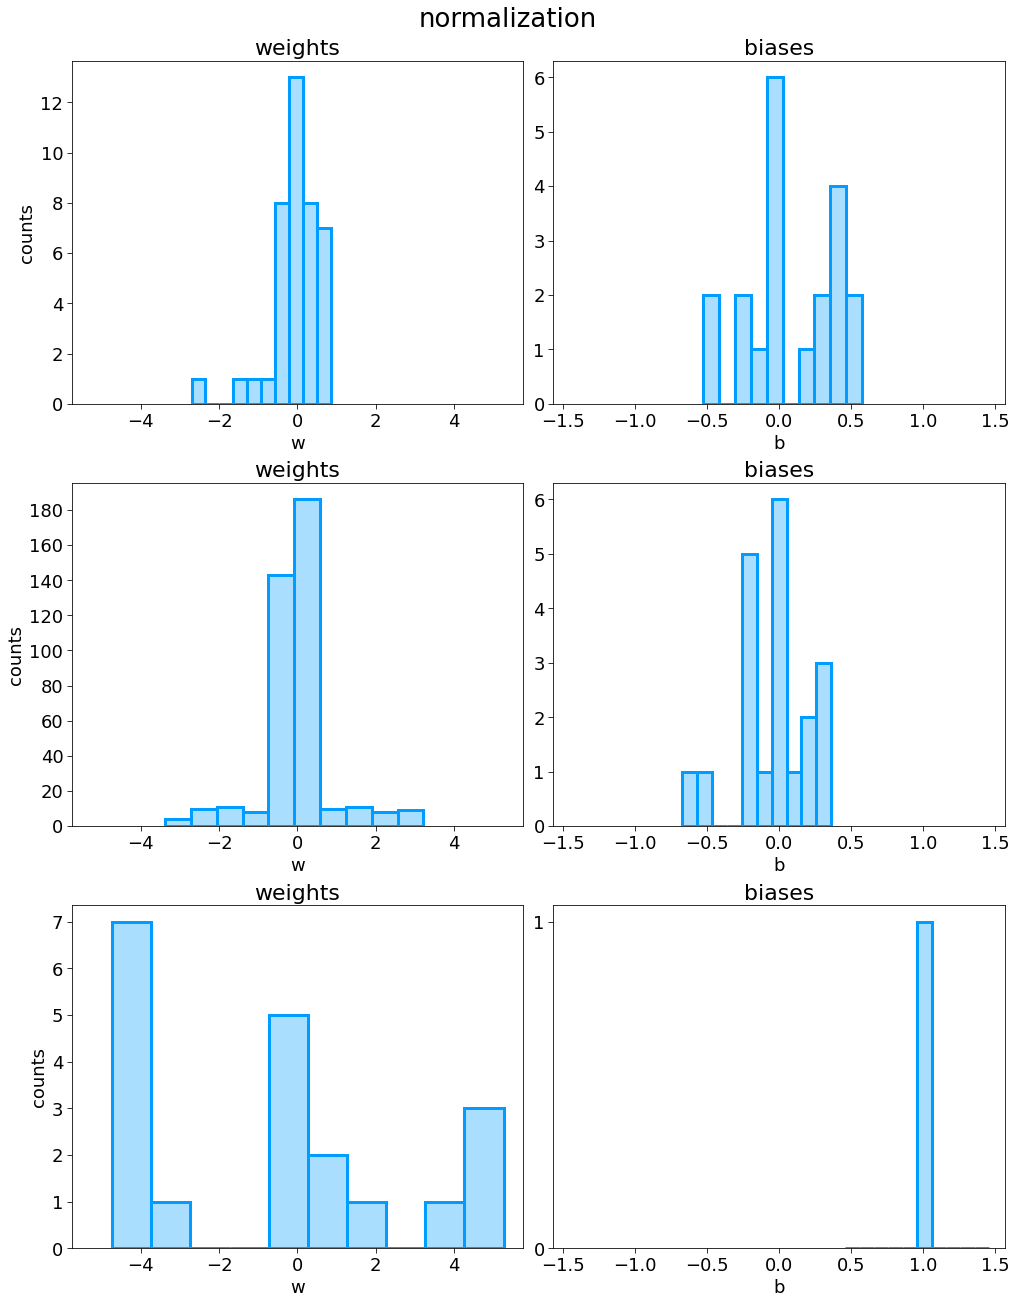

In [8]:
for i, network in enumerate(networks):

    weights = network.get_weights()

    axes = plot_utils.plot_weights(
        weights  = weights,
        figsize  = (14, 18),
        suptitle = titles[i],
    )

    plt.show()

### Neural network predictions on *test set*

In [9]:
predictions        = []
binary_predictions = []
confusion_matrices = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(test_set[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

    cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    confusion_matrices.append(cm)

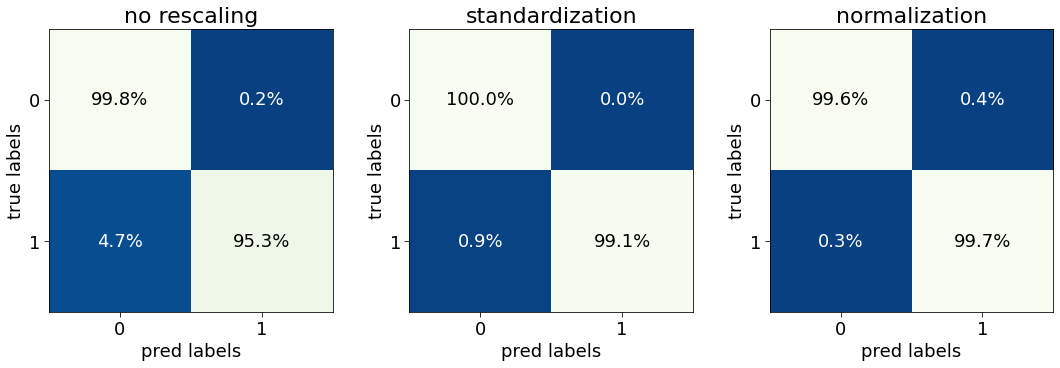

In [10]:
labels = [0, 1]
fontsize=18

fig = plt.figure(figsize=(15,5), constrained_layout=True)

for i, cm in enumerate(confusion_matrices):

    ax = fig.add_subplot(131+i)

    total_0, total_1 =  np.sum(cm, axis=1)
 
    cm_norm_0 = cm[0]/total_0
    cm_norm_1 = cm[1]/total_1

    cm_norm = np.vstack((cm_norm_0, cm_norm_1))

    plot_utils.plot_confusion_matrix(
        cm = cm_norm,
        ax = ax,
        title = titles[i]
    )
    

plt.show()

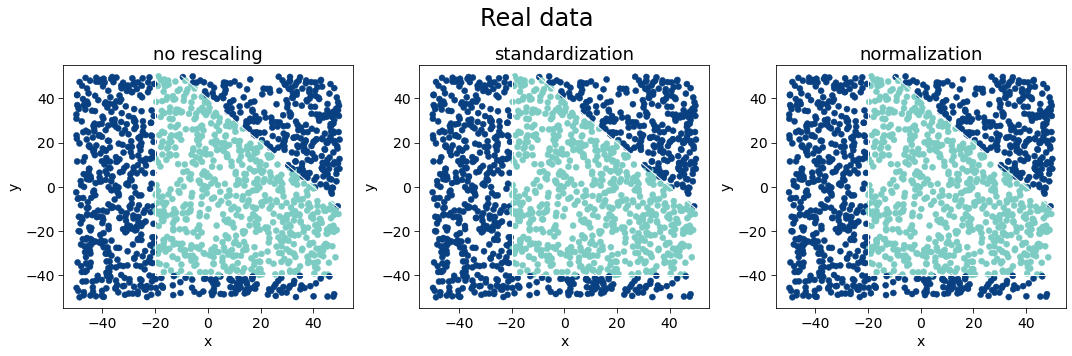

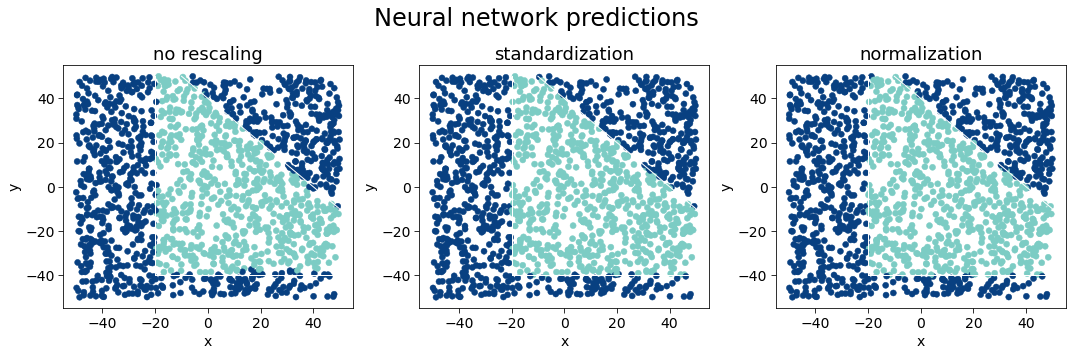

In [11]:
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle("Real data", fontsize=24)
fig2 = plt.figure(figsize=(15,5))
fig2.suptitle("Neural network predictions", fontsize=24)
for i in range(len(dataset)):

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = test_labels[i],
        fig             = fig1, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = binary_predictions[i], 
        fig             = fig2, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")


plt.show()

---

## Weights initializers

- ```tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)```
- ```tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)```
- ```tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)```
- ```tf.keras.initializers.Zeros()```
- ```tf.keras.initializers.Ones()```
- ```tf.keras.initializers.GlorotNormal(seed=None)```
- ```tf.keras.initializers.GlorotUniform(seed=None)```
- ```tf.keras.initializers.HeNormal(seed=None)```
- ```tf.keras.initializers.HeUniform(seed=None)```
- ```tf.keras.initializers.Identity(gain=1.0)```
- ```tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None)```

### Neural network hyper-parameters

In [12]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [2] # [2]
dropout_rates     = [0.2] # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "RMSprop"
metrics   = [
    tf.keras.metrics.Accuracy(name="accuracy"),
]

# list of initializers 
initializer_list = [
    "random_normal",
    "random_uniform",
    "truncated_normal",
    "glorot_normal",
    "glorot_uniform",
    "he_normal",
    "he_uniform",
    # "zeros",
    # "ones",
]

### GridSearch cross validation

In [13]:
N_epochs  = 200
minibatch = 64

grid_search_results = []

gs_means, gs_stds, gs_params = [], [], []

predictions        = []
binary_predictions = []

confusion_matrices = []

for i in range(len(dataset)):

    model_gridsearch = KerasClassifier(
        build_fn          = nn_model.create_model, 
        input_dim         = input_dim,
        architecture      = architecture,
        epochs            = N_epochs, 
        batch_size        = minibatch
    )

    param_grid = dict(initializer = initializer_list)

    grid_search = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

    grid_result = grid_search.fit(
        training_set[i], training_labels[i],
        # batch_size = minibatch,
        verbose    = 0,
    )

    grid_search_results.append(grid_result)


    # summarize results
    print("="*30)
    print()
    print(titles[i])
    print()
    print("Best model    : %.4f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print()

    means  = grid_result.cv_results_['mean_test_score']
    stds   = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    gs_means.append(means)
    gs_stds.append(stds)
    gs_params.append(params)

    for mean, stdev, param in zip(means, stds, params):
        print("%.4f (%.4f) with: %r" % (mean, stdev, param))
    print()
    print("="*30)

    

    # y_pred = grid_search.predict(test_set[i])
    # predictions.append(plot_utils.flatten(y_pred))

    # pred_binary = y_pred.copy()
    # pred_binary[y_pred <= 0.5] = 0
    # pred_binary[y_pred >  0.5] = 1
    # binary_predictions.append(plot_utils.flatten(pred_binary))

    # cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    # confusion_matrices.append(cm)


no rescaling

Best model    : 0.9886 using {'initializer': 'random_normal'}

0.9886 (0.0043) with: {'initializer': 'random_normal'}
0.9879 (0.0043) with: {'initializer': 'random_uniform'}
0.9868 (0.0046) with: {'initializer': 'truncated_normal'}
0.9800 (0.0077) with: {'initializer': 'glorot_normal'}
0.9811 (0.0041) with: {'initializer': 'glorot_uniform'}
0.9743 (0.0052) with: {'initializer': 'he_normal'}
0.9771 (0.0023) with: {'initializer': 'he_uniform'}


standardization

Best model    : 0.9968 using {'initializer': 'random_uniform'}

0.9943 (0.0036) with: {'initializer': 'random_normal'}
0.9968 (0.0033) with: {'initializer': 'random_uniform'}
0.9968 (0.0016) with: {'initializer': 'truncated_normal'}
0.9921 (0.0033) with: {'initializer': 'glorot_normal'}
0.9950 (0.0026) with: {'initializer': 'glorot_uniform'}
0.9921 (0.0021) with: {'initializer': 'he_normal'}
0.9911 (0.0043) with: {'initializer': 'he_uniform'}


normalization

Best model    : 0.9925 using {'initializer': 'random_uni

### GridSearch results

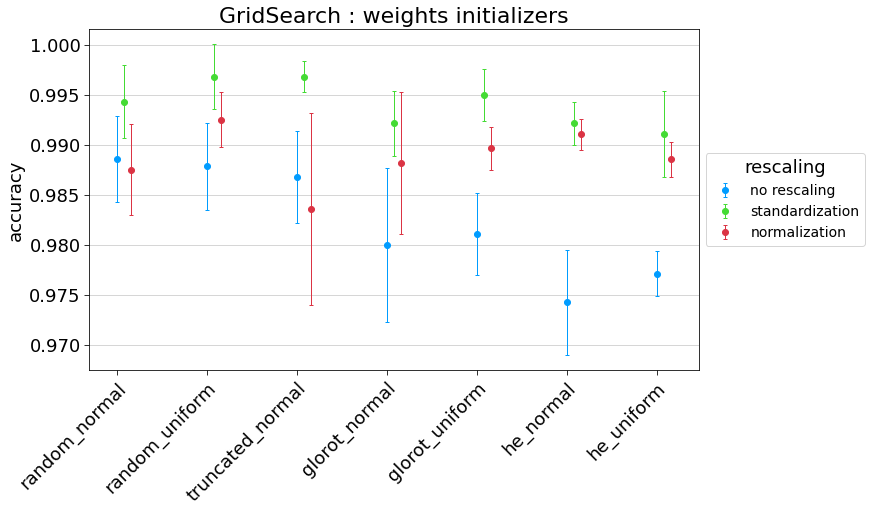

In [14]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = grid_search_results,
    fig        = fig,
    fontsize   = 18,
    colors     = palette,
    labels     = titles,
    legend     = True,
    title      = "GridSearch : weights initializers"
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

### Training the best model

In [15]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [2] # [1]
dropout_rates     = [0.2] # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "RMSprop"
metrics   = ["accuracy"]
initializer_list = [
    "random_uniform",
    "random_normal",
    "random_normal",
]

In [16]:
# training parameters
minibatch = 64
N_epochs  = 200

networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        initializer       = initializer_list[i],
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)


no rescaling training : 22.85 seconds

training loss     : 0.04632
training accuracy : 0.98214

valid loss        : 0.04010
valid accuracy    : 0.98571


no rescaling testing

test loss         : 0.05375
test accuracy     : 0.97667


standardization training : 21.86 seconds

training loss     : 0.02398
training accuracy : 0.99143

valid loss        : 0.01857
valid accuracy    : 0.99429


standardization testing

test loss         : 0.02259
test accuracy     : 0.99400


normalization training : 41.71 seconds

training loss     : 0.14411
training accuracy : 0.95250

valid loss        : 0.09812
valid accuracy    : 0.99143


normalization testing

test loss         : 0.09988
test accuracy     : 0.99067



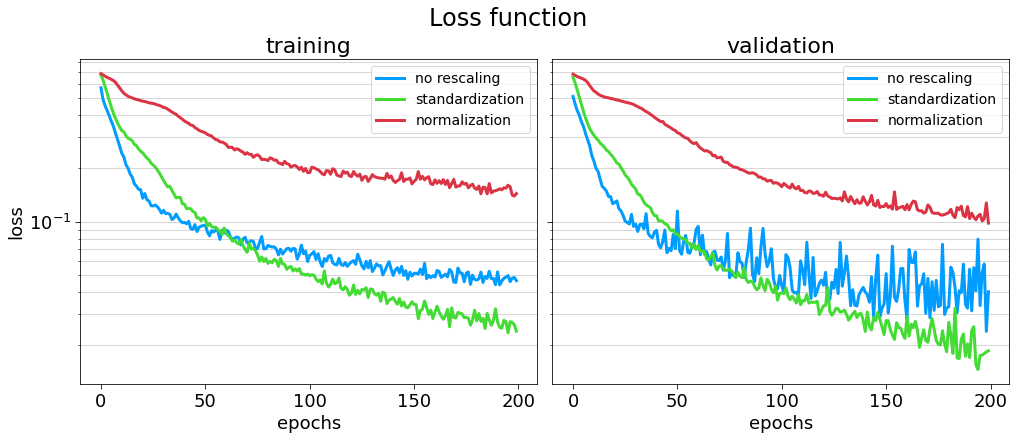

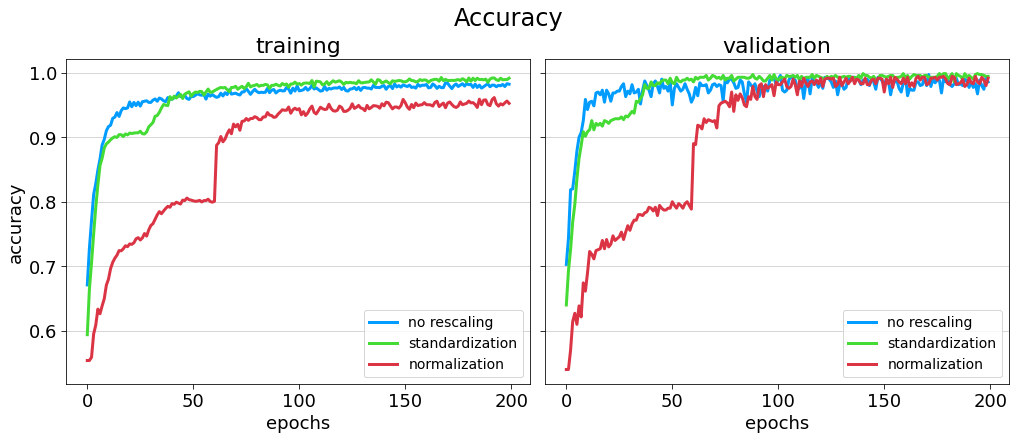

In [17]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

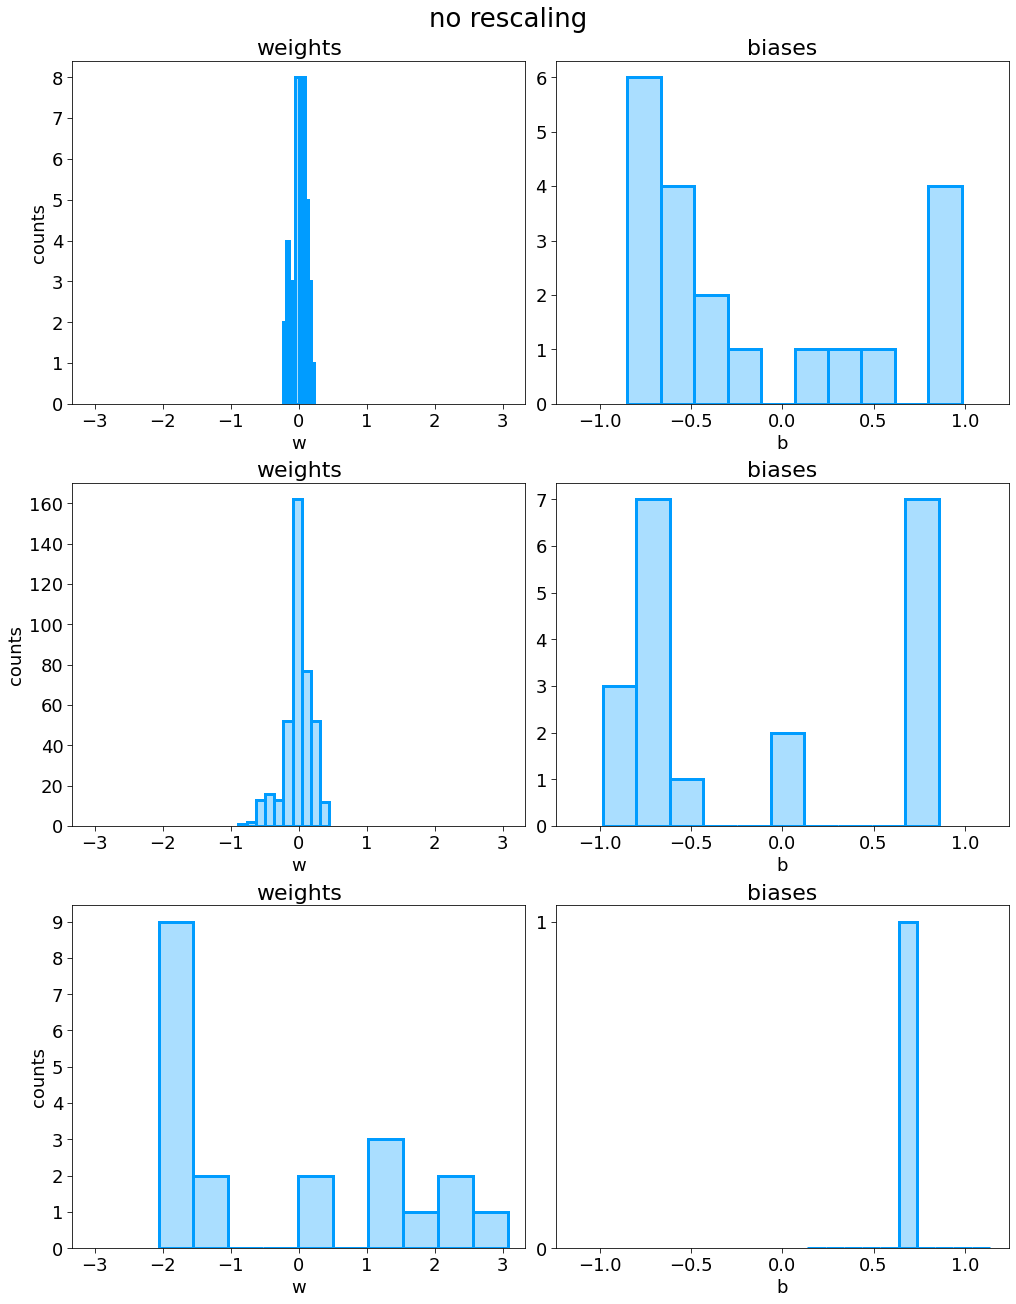

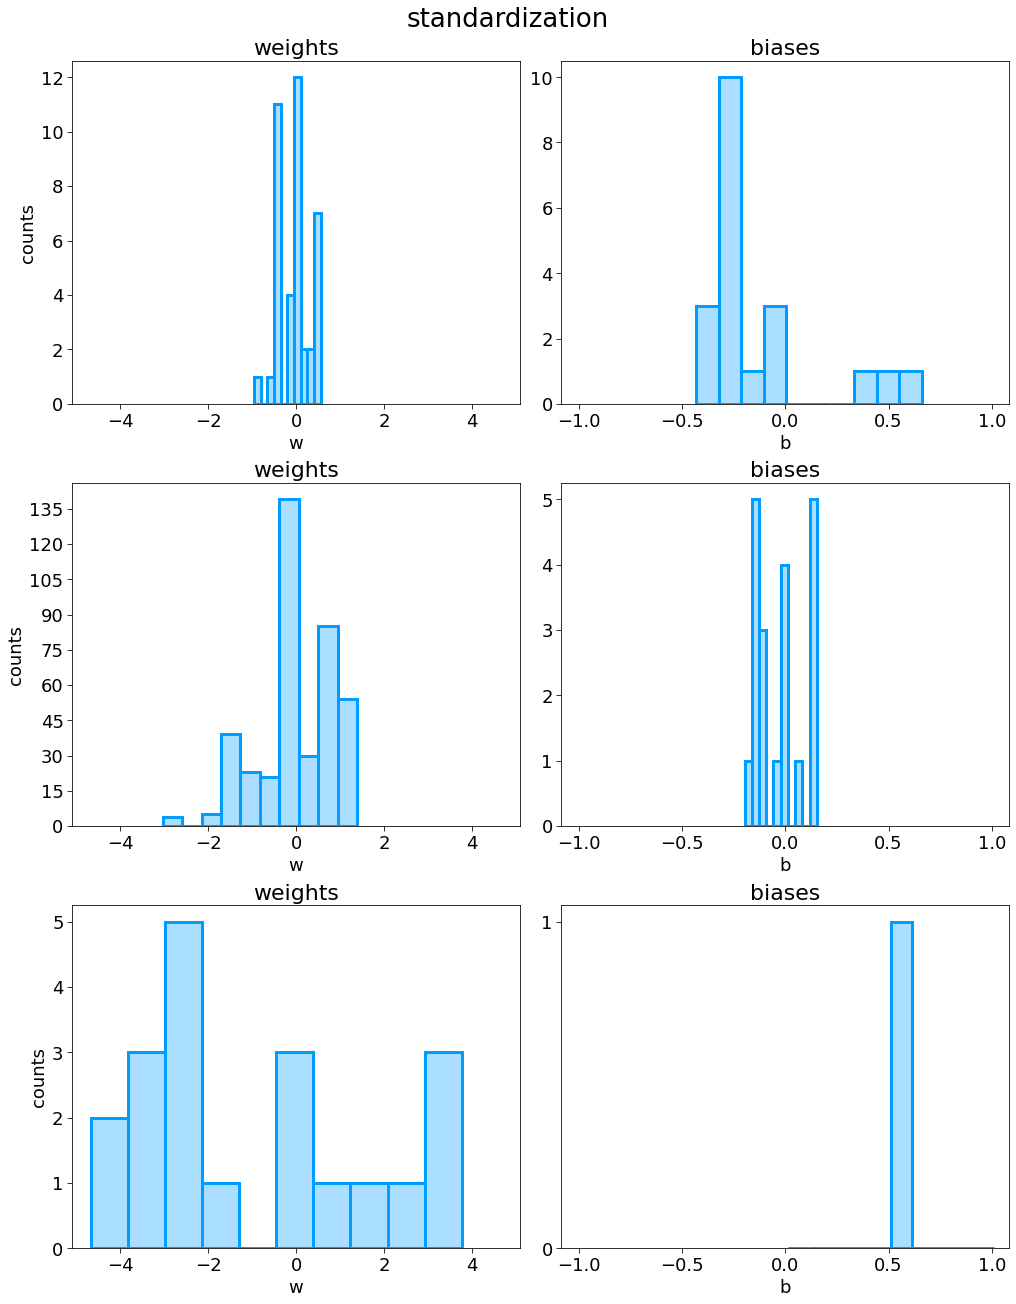

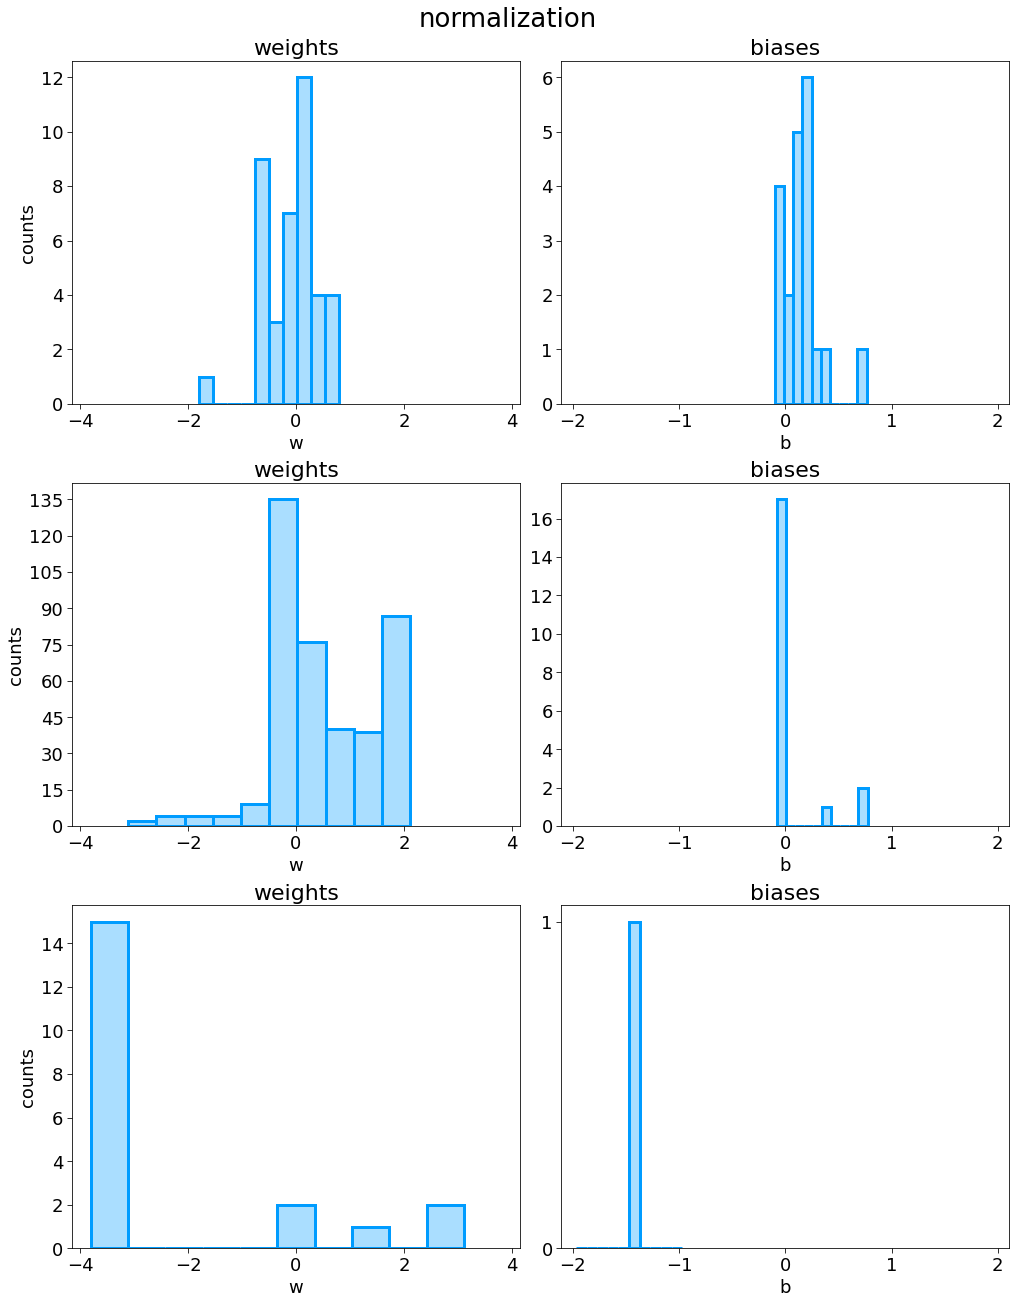

In [18]:
for i, network in enumerate(networks):

    weights = network.get_weights()

    axes = plot_utils.plot_weights(
        weights  = weights,
        figsize  = (14, 18),
        suptitle = titles[i],
    )

    plt.show()

### Neural network predictions

In [19]:
predictions        = []
binary_predictions = []
confusion_matrices = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(test_set[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

    cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    confusion_matrices.append(cm)

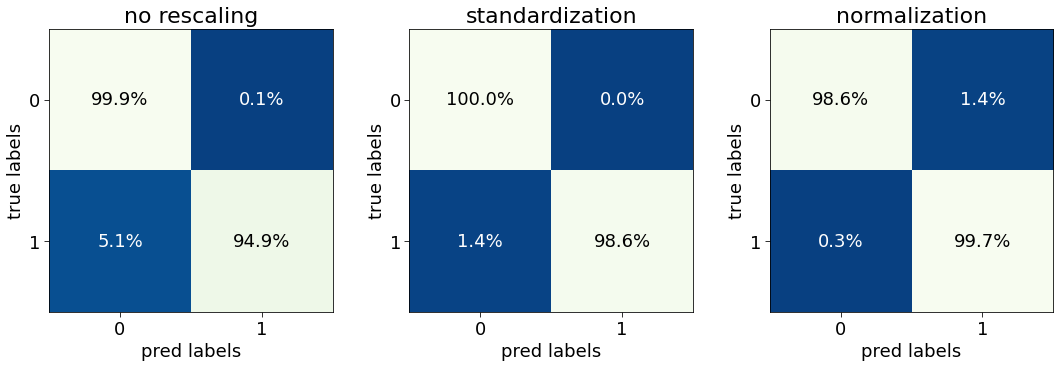

In [20]:
labels = [0, 1]
fontsize=18

fig = plt.figure(figsize=(15,5), constrained_layout=True)

for i, cm in enumerate(confusion_matrices):

    ax = fig.add_subplot(131+i)

    total_0, total_1 =  np.sum(cm, axis=1)
 
    cm_norm_0 = cm[0]/total_0
    cm_norm_1 = cm[1]/total_1

    cm_norm = np.vstack((cm_norm_0, cm_norm_1))

    plot_utils.plot_confusion_matrix(
        cm = cm_norm,
        ax = ax,
        title = titles[i]
    )
    

plt.show()

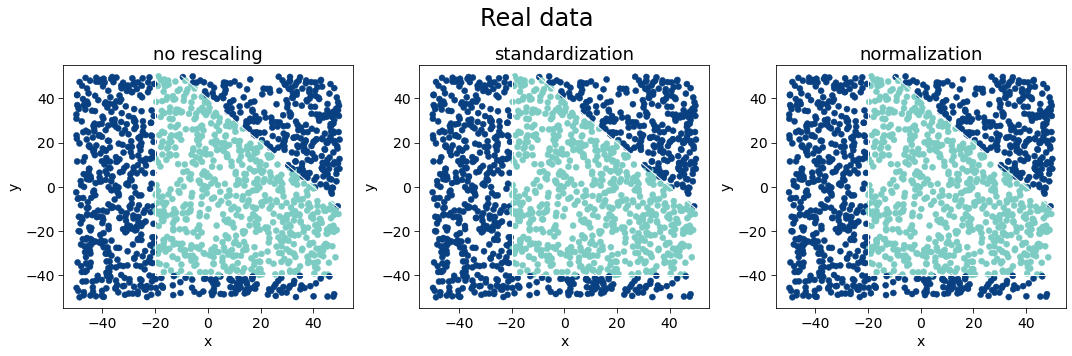

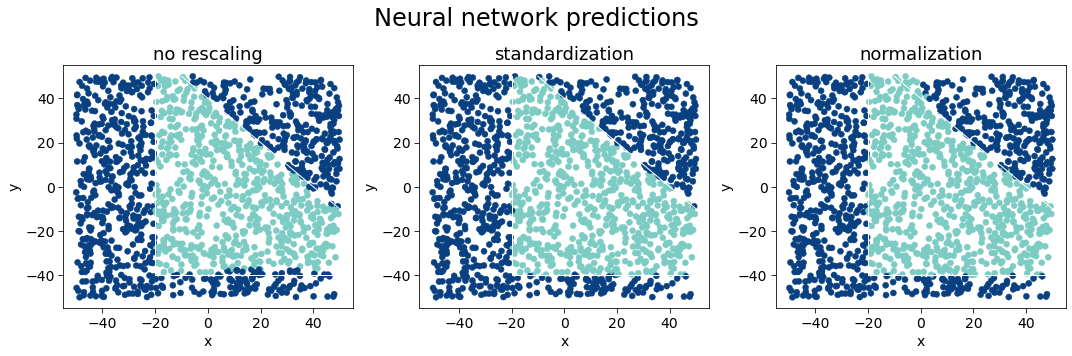

In [21]:
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle("Real data", fontsize=24)
fig2 = plt.figure(figsize=(15,5))
fig2.suptitle("Neural network predictions", fontsize=24)
for i in range(len(dataset)):

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = test_labels[i],
        fig             = fig1, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = binary_predictions[i], 
        fig             = fig2, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")


plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>